# pg_server___cron_jobs
Provides information about cron jobs running in the DB. 

Cells: 
- Configure: Connect to a specfic DB
- Current size of each table: in KB, dead rows, bloat, data size, all indexes size,  

In [16]:
import sqlalchemy
import pandas as pd
import configparser
import matplotlib.pyplot as plt 
from IPython.display import HTML

# Read from the Config file
config = configparser.ConfigParser() 
# As long as the notebook in the "Notebooks_Drafts" folder, use r'../../ipynb.cfg'
config.read_file(open(r'../../ipynb.cfg'))

con_str = config.get('con_str', 'PG_AIRBASES') 
engine = sqlalchemy.create_engine(con_str)

try:
    connection = engine.connect()
    print ("Opened Connection")
except (Exception, sqlalchemy.exc.SQLAlchemyError) as error:
    print("Error while connecting to PostgreSQL database:", error)


Opened Connection


## Configuration
View the configurations related to the cron jobs in the current DB

In [5]:
qry_cron_configuration = """
-- Cron Jobs
SELECT name, setting, short_desc, extra_desc, source, min_val, max_val
FROM pg_settings 
WHERE name like '%%cron%%' 
"""
df = pd.read_sql_query(qry_cron_configuration, connection)
df


,name,setting,short_desc,extra_desc,source,min_val,max_val
0,cron.database_name,airbases,Database in which pg_cron metadata is kept.,None,configuration file,None,None
1,cron.enable_superuser_jobs,on,Allow jobs to be scheduled as superuser,None,default,None,None
2,cron.host,localhost,Hostname to connect to postgres.,This setting has no effect when background wor...,default,None,None
3,cron.log_min_messages,warning,log_min_messages for the launcher bgworker.,None,configuration file,None,None
4,cron.log_run,on,Log all jobs runs into the job_run_details table,None,configuration file,None,None
5,cron.log_statement,on,Log all cron statements prior to execution.,None,configuration file,None,None
6,cron.max_running_jobs,1,Maximum number of jobs that can run concurrently.,None,configuration file,0,7
7,cron.use_background_workers,on,Use background workers instead of client sessi...,None,configuration file,None,None


## Number of jobs and size of the history table

In [20]:
qry_jobs_tables_stats = """ 
SELECT 
	min(j.count_jobs) as count_jobs, 
	count(jobid) as count_history_rows, 
  min(start_time) as oldest_job_history,
  now() -  min(start_time) as oldest_job_history_str,
  max(start_time) as newest_job_history
FROM cron.job_run_details AS rd
cross join ( SELECT count(*) as count_jobs
from cron.job) as j """ 
df = pd.read_sql_query(qry_jobs_tables_stats, connection)
df 



,count_jobs,count_history_rows,oldest_job_history,oldest_job_history_str,newest_job_history
0,6,114106,2023-05-21 15:30:00.068394+00:00,105 days 06:00:58.744481,2023-09-03 21:32:00.085105+00:00


## Analyze the size of the job_run_details
If the value is higher than 10,000 (feel free to select any other value) then you should run a daily job to delete data older than 7 days (or any other history length)

TODO: write here the command: 

In [19]:
# Find the value of the 'count_history_rows' column
value = df['count_history_rows'].iloc[0]

# Check if the value is higher than 10000 and display it in red if true
if value > 10000:
    message = f"<font color='red'>The value of count_history_rows ({value}) is higher than 10000</font>"
else:
    message = f"The value of count_history_rows ({value}) is within the allowed limit."

# Display the message with HTML formatting
display(HTML(message))

## Testing Mini series
Aug 21 - test failed. Can't show it all in one object. 

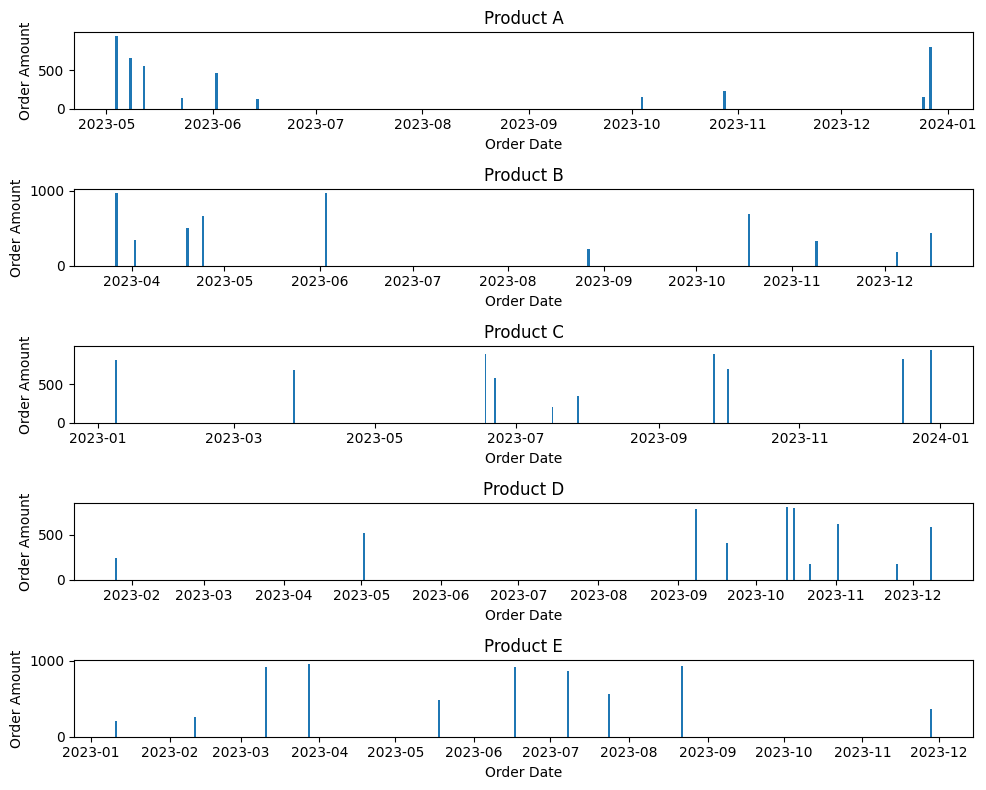

In [5]:
import pandas as pd
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Create empty DataFrame
data = {
    'product_name': [],
    'orderdate': [],
    'order_amount': []
}

# List of products
products = ['Product A', 'Product B', 'Product C', 'Product D', 'Product E']

# Generate 10 random dates for each product
for product in products:
    for _ in range(10):
        random_date = datetime(2023, random.randint(1, 12), random.randint(1, 28))
        data['product_name'].append(product)
        data['orderdate'].append(random_date)
        data['order_amount'].append(random.randint(100, 1000))

# Create DataFrame
df = pd.DataFrame(data)

# Print the DataFrame
# print(df)
# Create subplots for each product
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(5, 1, figure=fig)

for i, product in enumerate(products):
    ax = fig.add_subplot(gs[i, 0])
    product_data = df[df['product_name'] == product]
    ax.bar(product_data['orderdate'], product_data['order_amount'])
    ax.set_title(product)
    ax.set_xlabel('Order Date')
    ax.set_ylabel('Order Amount')

plt.tight_layout()
plt.show()

More tests


In [6]:
import pandas as pd
from datetime import datetime, timedelta

# Generate data
data = {
    'snapshot_id': [],
    'insert_date': [],
    'db_name': [],
    'rows_read': []
}

# Start date and time
start_time = datetime(2023, 1, 1, 10, 0)

# Generate snapshots
for i in range(100):
    snapshot_id = i + 1
    insert_date = start_time + timedelta(minutes=i)
    db_name = 'db_1'
    rows_read = 5000 + i * 90  # Increasing rows
    
    data['snapshot_id'].append(snapshot_id)
    data['insert_date'].append(insert_date)
    data['db_name'].append(db_name)
    data['rows_read'].append(rows_read)

# Create DataFrame
df = pd.DataFrame(data)

# Print the DataFrame
print(df)


# Calcylate the diff
import pandas as pd
from datetime import timedelta

# Your code to generate the initial DataFrame goes here...

# Sort the DataFrame by insert_date
df.sort_values('insert_date', inplace=True)

# Calculate the diff of rows_read for every minute
# The .diff() function is a pandas method that calculates the difference between each value and the previous value in a Series. It returns a new Series where each value is the difference between the corresponding value and the value that came before it.
df['rows_read_diff'] = df['rows_read'].diff()

# Print the new DataFrame
print(df)


    snapshot_id         insert_date db_name  rows_read
0             1 2023-01-01 10:00:00    db_1       5000
1             2 2023-01-01 10:01:00    db_1       5090
2             3 2023-01-01 10:02:00    db_1       5180
3             4 2023-01-01 10:03:00    db_1       5270
4             5 2023-01-01 10:04:00    db_1       5360
..          ...                 ...     ...        ...
95           96 2023-01-01 11:35:00    db_1      13550
96           97 2023-01-01 11:36:00    db_1      13640
97           98 2023-01-01 11:37:00    db_1      13730
98           99 2023-01-01 11:38:00    db_1      13820
99          100 2023-01-01 11:39:00    db_1      13910

[100 rows x 4 columns]
    snapshot_id         insert_date db_name  rows_read  rows_read_diff
0             1 2023-01-01 10:00:00    db_1       5000             NaN
1             2 2023-01-01 10:01:00    db_1       5090            90.0
2             3 2023-01-01 10:02:00    db_1       5180            90.0
3             4 2023-01-01 10:03